In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [7]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

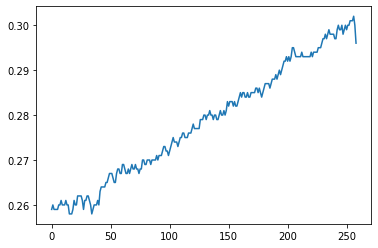

In [8]:
df.plot()

In [9]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [11]:
train = df_scaled

In [12]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [14]:
x_train.shape

(191, 20, 1)

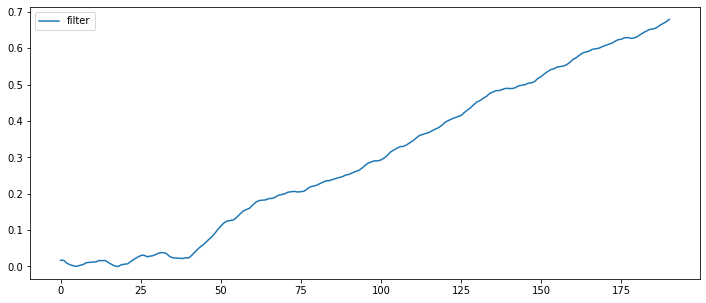

In [15]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

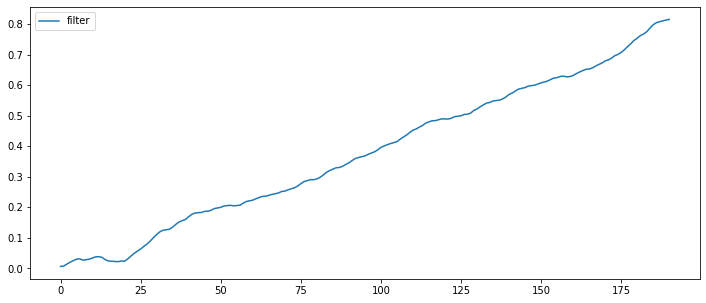

In [16]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [17]:
OUT_STEPS = 20

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [19]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Train on 191 samples
Epoch 1/1000
191/191 [==============================] - 3s 14ms/sample - loss: 0.1468 - mean_absolute_error: 0.3135
Epoch 2/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.1194 - mean_absolute_error: 0.2784
Epoch 3/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.0739 - mean_absolute_error: 0.2076
Epoch 4/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.0326 - mean_absolute_error: 0.1260
Epoch 5/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.0137 - mean_absolute_error: 0.0884
Epoch 6/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.0059 - mean_absolute_error: 0.0613
Epoch 7/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.0035 - mean_absolute_error: 0.0458
Epoch 8/1000
191/191 [==============================] - 0s 2ms/sample - loss: 0.0029 - mean_absolute_error: 0.0423
Epoch 9/1000
191/191 [==============================] - 0s

191/191 [==============================] - 0s 2ms/sample - loss: 8.4390e-05 - mean_absolute_error: 0.0073
Epoch 70/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.3447e-05 - mean_absolute_error: 0.0072
Epoch 71/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.3467e-05 - mean_absolute_error: 0.0072
Epoch 72/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.3116e-05 - mean_absolute_error: 0.0072
Epoch 73/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.4720e-05 - mean_absolute_error: 0.0072
Epoch 74/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.5467e-05 - mean_absolute_error: 0.0073
Epoch 75/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.4844e-05 - mean_absolute_error: 0.0073
Epoch 76/1000
191/191 [==============================] - 0s 2ms/sample - loss: 8.1773e-05 - mean_absolute_error: 0.0071
Epoch 77/1000
191/191 [==============================]

191/191 [==============================] - 0s 2ms/sample - loss: 6.8697e-05 - mean_absolute_error: 0.0066
Epoch 138/1000
191/191 [==============================] - 0s 2ms/sample - loss: 6.9634e-05 - mean_absolute_error: 0.0067
Epoch 139/1000
191/191 [==============================] - 0s 2ms/sample - loss: 6.9600e-05 - mean_absolute_error: 0.0067
Epoch 140/1000
191/191 [==============================] - 0s 2ms/sample - loss: 6.6434e-05 - mean_absolute_error: 0.0065
Epoch 141/1000
191/191 [==============================] - 0s 2ms/sample - loss: 6.5931e-05 - mean_absolute_error: 0.0065
Epoch 142/1000
191/191 [==============================] - 0s 2ms/sample - loss: 6.7327e-05 - mean_absolute_error: 0.0066
Epoch 143/1000
191/191 [==============================] - 0s 2ms/sample - loss: 7.1153e-05 - mean_absolute_error: 0.0067
Epoch 144/1000
191/191 [==============================] - 0s 2ms/sample - loss: 6.9677e-05 - mean_absolute_error: 0.0067
Epoch 145/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 5.1771e-05 - mean_absolute_error: 0.0057
Epoch 205/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.1327e-05 - mean_absolute_error: 0.0057
Epoch 206/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.0480e-05 - mean_absolute_error: 0.0056
Epoch 207/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.1392e-05 - mean_absolute_error: 0.0057
Epoch 208/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.9821e-05 - mean_absolute_error: 0.0061
Epoch 209/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.5779e-05 - mean_absolute_error: 0.0059
Epoch 210/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.2550e-05 - mean_absolute_error: 0.0058
Epoch 211/1000
191/191 [==============================] - 0s 2ms/sample - loss: 5.2536e-05 - mean_absolute_error: 0.0057
Epoch 212/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 4.3927e-05 - mean_absolute_error: 0.0052
Epoch 272/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.8684e-05 - mean_absolute_error: 0.0049
Epoch 273/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.8120e-05 - mean_absolute_error: 0.0049
Epoch 274/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.7664e-05 - mean_absolute_error: 0.0049
Epoch 275/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.6542e-05 - mean_absolute_error: 0.0048
Epoch 276/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.5639e-05 - mean_absolute_error: 0.0047
Epoch 277/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.7891e-05 - mean_absolute_error: 0.0049
Epoch 278/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.7113e-05 - mean_absolute_error: 0.0048
Epoch 279/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 3.0298e-05 - mean_absolute_error: 0.0043
Epoch 339/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.1565e-05 - mean_absolute_error: 0.0044
Epoch 340/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.9633e-05 - mean_absolute_error: 0.0043
Epoch 341/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.0464e-05 - mean_absolute_error: 0.0043
Epoch 342/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.7267e-05 - mean_absolute_error: 0.0042
Epoch 343/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.6394e-05 - mean_absolute_error: 0.0040
Epoch 344/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.9808e-05 - mean_absolute_error: 0.0043
Epoch 345/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.8775e-05 - mean_absolute_error: 0.0042
Epoch 346/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 2.1424e-05 - mean_absolute_error: 0.0036
Epoch 406/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.0908e-05 - mean_absolute_error: 0.0036
Epoch 407/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.2554e-05 - mean_absolute_error: 0.0037
Epoch 408/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.1615e-05 - mean_absolute_error: 0.0036
Epoch 409/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.4645e-05 - mean_absolute_error: 0.0039
Epoch 410/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.1729e-05 - mean_absolute_error: 0.0037
Epoch 411/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.6713e-05 - mean_absolute_error: 0.0040
Epoch 412/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.6546e-05 - mean_absolute_error: 0.0040
Epoch 413/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 1.9907e-05 - mean_absolute_error: 0.0035
Epoch 473/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.9828e-05 - mean_absolute_error: 0.0035
Epoch 474/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.9835e-05 - mean_absolute_error: 0.0035
Epoch 475/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.9849e-05 - mean_absolute_error: 0.0042
Epoch 476/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.4111e-05 - mean_absolute_error: 0.0039
Epoch 477/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.2618e-05 - mean_absolute_error: 0.0038
Epoch 478/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.3820e-05 - mean_absolute_error: 0.0038
Epoch 479/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.3192e-05 - mean_absolute_error: 0.0038
Epoch 480/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 2.2342e-05 - mean_absolute_error: 0.0037
Epoch 540/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8688e-05 - mean_absolute_error: 0.0034
Epoch 541/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8956e-05 - mean_absolute_error: 0.0034
Epoch 542/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.7612e-05 - mean_absolute_error: 0.0033
Epoch 543/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.7535e-05 - mean_absolute_error: 0.0040
Epoch 544/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.1418e-05 - mean_absolute_error: 0.0043
Epoch 545/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.1760e-05 - mean_absolute_error: 0.0036
Epoch 546/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.1846e-05 - mean_absolute_error: 0.0037
Epoch 547/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 1.7225e-05 - mean_absolute_error: 0.0033
Epoch 607/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.7106e-05 - mean_absolute_error: 0.0033
Epoch 608/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.7522e-05 - mean_absolute_error: 0.0033
Epoch 609/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.9608e-05 - mean_absolute_error: 0.0035
Epoch 610/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.0613e-05 - mean_absolute_error: 0.0036
Epoch 611/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6588e-05 - mean_absolute_error: 0.0032
Epoch 612/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.7989e-05 - mean_absolute_error: 0.0033
Epoch 613/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.9544e-05 - mean_absolute_error: 0.0034
Epoch 614/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 1.7924e-05 - mean_absolute_error: 0.0033
Epoch 674/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6081e-05 - mean_absolute_error: 0.0031
Epoch 675/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.9937e-05 - mean_absolute_error: 0.0035
Epoch 676/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8165e-05 - mean_absolute_error: 0.0033
Epoch 677/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8700e-05 - mean_absolute_error: 0.0034
Epoch 678/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8334e-05 - mean_absolute_error: 0.0034
Epoch 679/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6456e-05 - mean_absolute_error: 0.0032
Epoch 680/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5960e-05 - mean_absolute_error: 0.0031
Epoch 681/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 1.6589e-05 - mean_absolute_error: 0.0032
Epoch 741/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6357e-05 - mean_absolute_error: 0.0032
Epoch 742/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6638e-05 - mean_absolute_error: 0.0032
Epoch 743/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8220e-05 - mean_absolute_error: 0.0033
Epoch 744/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5537e-05 - mean_absolute_error: 0.0031
Epoch 745/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5876e-05 - mean_absolute_error: 0.0031
Epoch 746/1000
191/191 [==============================] - 0s 2ms/sample - loss: 3.0031e-05 - mean_absolute_error: 0.0042
Epoch 747/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.8454e-05 - mean_absolute_error: 0.0042
Epoch 748/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 1.4864e-05 - mean_absolute_error: 0.0030
Epoch 808/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.4505e-05 - mean_absolute_error: 0.0030
Epoch 809/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6869e-05 - mean_absolute_error: 0.0032
Epoch 810/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5503e-05 - mean_absolute_error: 0.0031
Epoch 811/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.4718e-05 - mean_absolute_error: 0.0030
Epoch 812/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5529e-05 - mean_absolute_error: 0.0031
Epoch 813/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6889e-05 - mean_absolute_error: 0.0033
Epoch 814/1000
191/191 [==============================] - 0s 2ms/sample - loss: 2.3373e-05 - mean_absolute_error: 0.0038
Epoch 815/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 1.6809e-05 - mean_absolute_error: 0.0033
Epoch 875/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5574e-05 - mean_absolute_error: 0.0031
Epoch 876/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.7534e-05 - mean_absolute_error: 0.0033
Epoch 877/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.7962e-05 - mean_absolute_error: 0.0033
Epoch 878/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8123e-05 - mean_absolute_error: 0.0033
Epoch 879/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8934e-05 - mean_absolute_error: 0.0034
Epoch 880/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5448e-05 - mean_absolute_error: 0.0031
Epoch 881/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5035e-05 - mean_absolute_error: 0.0031
Epoch 882/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/sample - loss: 2.6098e-05 - mean_absolute_error: 0.0040
Epoch 942/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.9923e-05 - mean_absolute_error: 0.0035
Epoch 943/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8937e-05 - mean_absolute_error: 0.0034
Epoch 944/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.8986e-05 - mean_absolute_error: 0.0034
Epoch 945/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.4413e-05 - mean_absolute_error: 0.0030
Epoch 946/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5581e-05 - mean_absolute_error: 0.0031
Epoch 947/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.6876e-05 - mean_absolute_error: 0.0032
Epoch 948/1000
191/191 [==============================] - 0s 2ms/sample - loss: 1.5047e-05 - mean_absolute_error: 0.0030
Epoch 949/1000
191/191 [=======================

num 0 1.0574459258653397 actual 0.7678454790416467 prediction 0.7597259
num 1 1.5093966976073288 actual 0.77236253191478 prediction 0.7607045
num 2 1.1369035995839933 actual 0.7831984687470737 prediction 0.77429426
num 3 3.1000817145984962 actual 0.799641825874609 prediction 0.7748523
num 4 3.5100828281943754 actual 0.8074062984174262 prediction 0.77906567
num 5 3.1850104077960415 actual 0.8074690701733829 prediction 0.7817511
num 6 1.8294083385237783 actual 0.8075247742535012 prediction 0.79275185
num 7 1.3633403544273577 actual 0.8075742064303526 prediction 0.7965642
num 8 1.015467983019747 actual 0.8144455464880203 prediction 0.8061751
num 9 1.4336602021278855 actual 0.8205432200556722 prediction 0.8087794
num 10 0.627591405767654 actual 0.8259543367557072 prediction 0.83113796
num 11 0.9956632148355441 actual 0.823928724645139 prediction 0.8321323
num 12 1.7221105671356127 actual 0.828958656389883 prediction 0.84323424
num 13 1.6159681970001478 actual 0.8402497253961947 prediction 

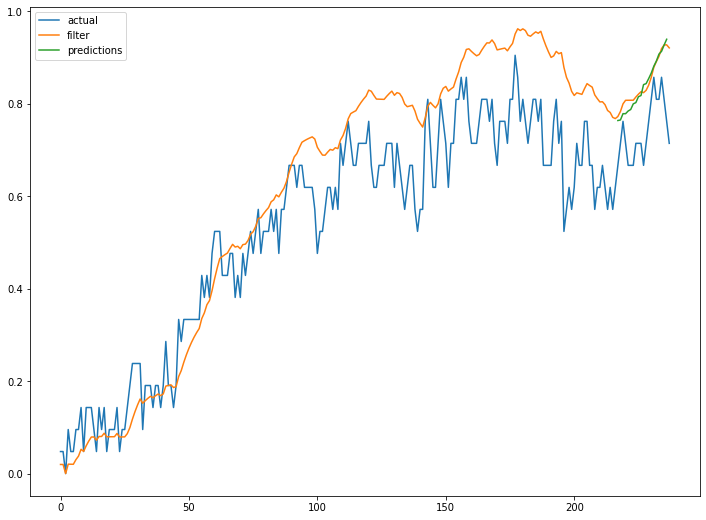

In [34]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.769936347494298 actual 0.8006535947712417 prediction 0.778476
num 1 3.097160929633726 actual 0.8104575163398693 prediction 0.78535634
num 2 2.055019930184605 actual 0.8137254901960784 prediction 0.79700327
num 3 2.8036280632019026 actual 0.8169934640522876 prediction 0.794088
num 4 2.3304494857788067 actual 0.8169934640522876 prediction 0.79795384
num 5 2.6984182961908436 actual 0.8202614379084967 prediction 0.79812735
num 6 2.3794376803009816 actual 0.826797385620915 prediction 0.80712426
num 7 3.4144077450036905 actual 0.8366013071895424 prediction 0.8080363
num 8 2.619147024559685 actual 0.8464052287581698 prediction 0.82423663
num 9 4.416997268282118 actual 0.8529411764705881 prediction 0.8152668
num 10 1.7856304183205534 actual 0.8594771241830064 prediction 0.84413004
num 11 2.883381057869284 actual 0.8627450980392155 prediction 0.83786887
num 12 2.2682829173105854 actual 0.8660130718954246 prediction 0.84636945
num 13 1.2960742554574425 actual 0.8660130718954246 predictio

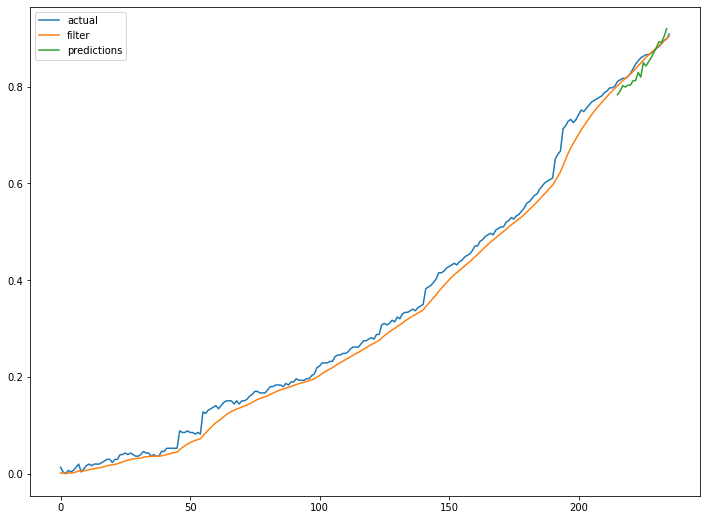

In [33]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.1450480771690947 actual 0.6741645981757491 prediction 0.68862575
num 1 1.289943571421639 actual 0.6816732631299811 prediction 0.69046646
num 2 1.3258289489933435 actual 0.6892877090729039 prediction 0.6984265
num 3 0.3827291052082334 actual 0.6966789571267178 prediction 0.69934535
num 4 0.27230134707861614 actual 0.7038721378665354 prediction 0.7057888
num 5 0.17186545096425218 actual 0.7112066209871992 prediction 0.7099843
num 6 0.030625911434305604 actual 0.7193006341003789 prediction 0.7195209
num 7 0.596099445721348 actual 0.7277515906050516 prediction 0.72341347
num 8 0.4488998490689497 actual 0.7365193010856859 prediction 0.73321307
num 9 0.8495656441858516 actual 0.7449339638779782 prediction 0.73860526
num 10 0.13419648580604068 actual 0.7536694670731638 prediction 0.75265807
num 11 0.5685591996425106 actual 0.7617384802500748 prediction 0.75740755
num 12 0.4371805335008798 actual 0.7688989770313381 prediction 0.7655375
num 13 0.09477644076008016 actual 0.77652152483926

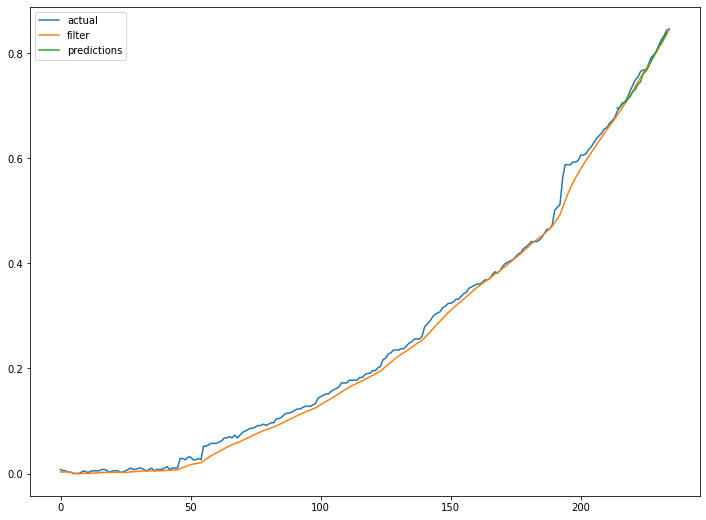

In [32]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.034499526998722 actual 0.8567772696870257 prediction 0.80507505
num 1 5.108095755734199 actual 0.8529820078135248 prediction 0.80941087
num 2 2.953992050505862 actual 0.8496140667985053 prediction 0.82451653
num 3 2.3567128222465326 actual 0.8411740347820782 prediction 0.82135
num 4 1.229263125569402 actual 0.8391355917940473 prediction 0.8288204
num 5 0.022969058797637536 actual 0.8318753653045423 prediction 0.8316843
num 6 1.0768644454854193 actual 0.836335188124858 prediction 0.8453414
num 7 0.2826481535119391 actual 0.8402928650116994 prediction 0.84266794
num 8 1.279386944698693 actual 0.8547075310399403 prediction 0.86564255
num 9 1.553209775532394 actual 0.8729505014289352 prediction 0.85939175
num 10 0.4819685485162786 actual 0.889139436542445 prediction 0.8934248
num 11 1.3606117122233514 actual 0.9035056068820939 prediction 0.8912124
num 12 1.6760153471987786 actual 0.9162542434527321 prediction 0.9008977
num 13 1.4844415608565305 actual 0.9275674696339422 prediction 

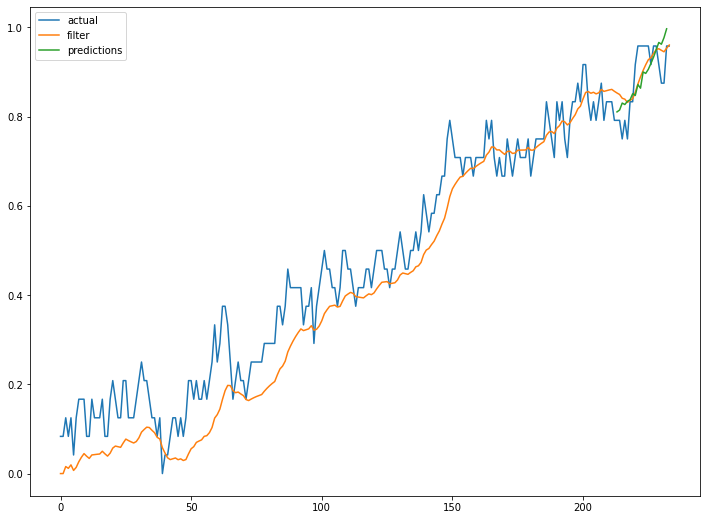

In [31]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.532969576872374 actual 0.8693799840566223 prediction 0.82997125
num 1 3.5437958823044102 actual 0.8717170120547708 prediction 0.84082514
num 2 2.0646362398844 actual 0.8727469133203258 prediction 0.85472786
num 3 2.785821917822025 actual 0.8741828512387402 prediction 0.8498297
num 4 2.9772314789435335 actual 0.8770231019861496 prediction 0.8509121
num 5 3.6902509926925 actual 0.8805875528403 prediction 0.84809166
num 6 3.1667844779508854 actual 0.8842726671788284 prediction 0.85626966
num 7 3.7852971382749656 actual 0.8885868556888945 prediction 0.8549512
num 8 1.914938258703432 actual 0.8918932991246966 prediction 0.8748141
num 9 4.445930815110223 actual 0.8953494559379216 prediction 0.85554284
num 10 0.41725216234913254 actual 0.8978944762518686 prediction 0.894148
num 11 2.4171556715236218 actual 0.901196937625746 prediction 0.8794136
num 12 1.8718351836435216 actual 0.9051715573110184 prediction 0.88822824
num 13 1.632111259363935 actual 0.9092206582400544 prediction 0.8943

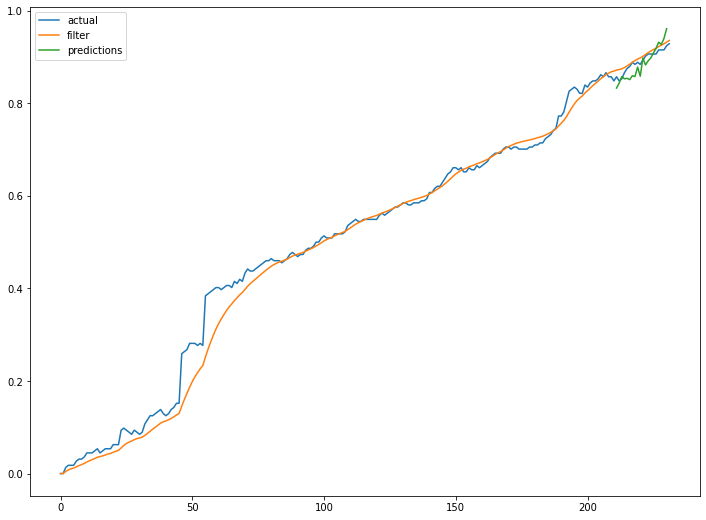

In [30]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.541430900383206 actual 0.8530179012740007 prediction 0.82280886
num 1 3.793456134077812 actual 0.8693396655198562 prediction 0.83636165
num 2 3.0825102509030042 actual 0.8753746898175159 prediction 0.8483912
num 3 4.296896004098897 actual 0.8807302111323061 prediction 0.84288615
num 4 5.024134356610515 actual 0.8854827369115768 prediction 0.8409949
num 5 6.113543310544305 actual 0.8897001603807411 prediction 0.83530796
num 6 5.0849901911367175 actual 0.8849937109355146 prediction 0.83999187
num 7 4.493194565990669 actual 0.8808171759163166 prediction 0.84124035
num 8 1.3882778886436835 actual 0.8686618710261627 prediction 0.85660243
num 9 3.648159771814309 actual 0.8663241908958383 prediction 0.8347193
num 10 0.3125797093335258 actual 0.872698737273403 prediction 0.86997086
num 11 3.0755139536384934 actual 0.8783555527746039 prediction 0.8513416
num 12 1.7939692604418052 actual 0.8749264295384656 prediction 0.8592305
num 13 1.2350829488352684 actual 0.8718834024226858 predictio

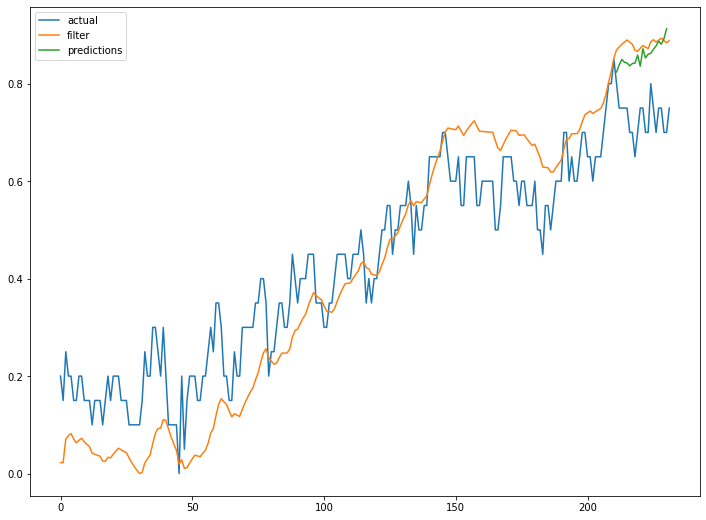

In [29]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.068582165834365 actual 0.845513034833238 prediction 0.81111264
num 1 3.710863482136342 actual 0.852231498354441 prediction 0.82060635
num 2 2.4820465488918337 actual 0.8549687041954082 prediction 0.833748
num 3 3.5464941277330833 actual 0.8606225231982547 prediction 0.8301006
num 4 4.089370004041094 actual 0.8656397603602377 prediction 0.83024055
num 5 4.5688262022430095 actual 0.8668672864420666 prediction 0.8272616
num 6 3.5071645678530263 actual 0.8647317973203767 prediction 0.83440423
num 7 3.138916629772236 actual 0.8628367498533533 prediction 0.835753
num 8 1.6476881315519984 actual 0.8643798759902142 prediction 0.8501376
num 9 3.588228713485027 actual 0.8657492565444178 prediction 0.8346842
num 10 0.23009337844670788 actual 0.870189258151199 prediction 0.868187
num 11 1.828041503520218 actual 0.8709045415034113 prediction 0.85498405
num 12 1.5746983831204577 actual 0.8779888968920782 prediction 0.8641632
num 13 1.3174203648610783 actual 0.8810507976470108 prediction 0.86

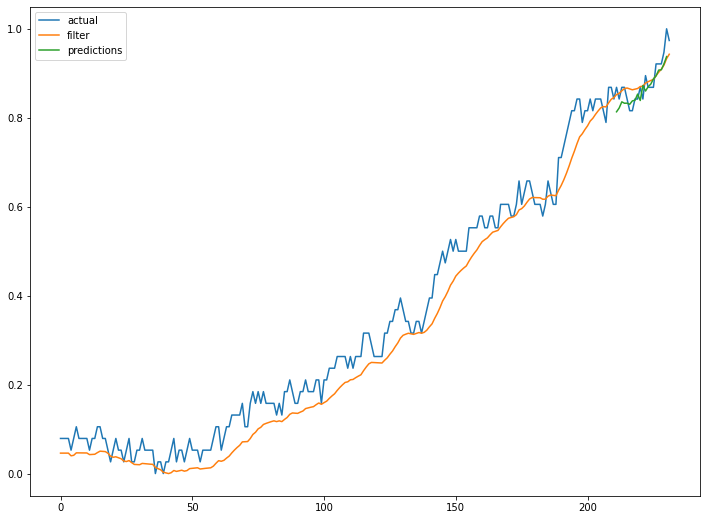

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.978571103164376 actual 0.8082544546553478 prediction 0.7760975
num 1 3.1768711244400087 actual 0.8079686547514928 prediction 0.78230053
num 2 1.6599521254828637 actual 0.8077150339868755 prediction 0.79430735
num 3 1.89642288144438 actual 0.8074899692077135 prediction 0.79217654
num 4 0.9502884477642474 actual 0.8022503455503411 prediction 0.79462665
num 5 1.6542305916808042 actual 0.8076804674399671 prediction 0.79431957
num 6 1.8372077622809555 actual 0.8175390939256442 prediction 0.8025192
num 7 2.6018778699362 actual 0.8262877056419295 prediction 0.8047887
num 8 2.570876078039769 actual 0.8390911824087333 prediction 0.8175192
num 9 4.243859574204419 actual 0.8454131744978035 prediction 0.809535
num 10 1.0718627480270109 actual 0.8459834533159754 prediction 0.8369157
num 11 1.9268878968721375 actual 0.8464895225901721 prediction 0.8301786
num 12 0.9190057731116853 actual 0.8469386118814572 prediction 0.8391552
num 13 0.6670715157355455 actual 0.8523770364036718 prediction 0.

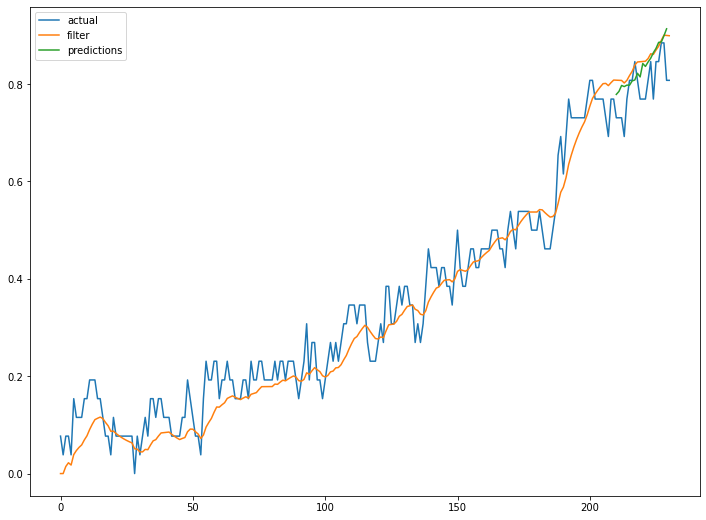

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 1.2414726793056305 actual 0.7522120566349304 prediction 0.74287355
num 1 1.2556501697566722 actual 0.7575234936893953 prediction 0.74801165
num 2 0.6409962656203262 actual 0.762831683895189 prediction 0.75794196
num 3 1.5347572975177657 actual 0.7681369928255475 prediction 0.75634795
num 4 1.7066073850705255 actual 0.7740345299894547 prediction 0.7608248
num 5 2.28936722030374 actual 0.7798628293901582 prediction 0.7620089
num 6 1.9121924695176318 actual 0.7856296867322505 prediction 0.77060694
num 7 2.2774046974854114 actual 0.7913420199766266 prediction 0.77331996
num 8 1.4032733946322775 actual 0.797005968168502 prediction 0.7858218
num 9 2.5279153753960686 actual 0.8026269791380558 prediction 0.78233725
num 10 0.460472719744471 actual 0.8082098873265771 prediction 0.8044883
num 11 1.3644170531351767 actual 0.8131641977530844 prediction 0.80206925
num 12 1.0429546709275093 actual 0.8187502564744669 prediction 0.81021106
num 13 0.8274684941682877 actual 0.8254917179955903 predi

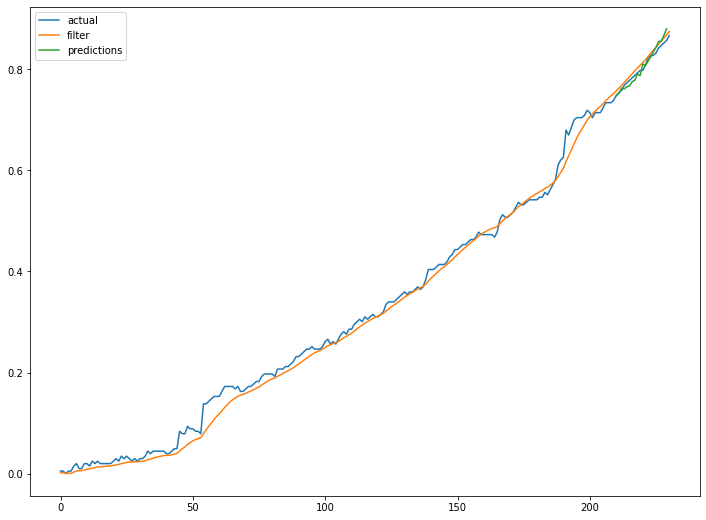

In [28]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

#error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(train_feature2[:, 0,0], label ='filter')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()